# Walmart Sales Forecasting: Data Exploration & Hydra Training

This notebook provides comprehensive data exploration, statistical analysis, and model training for Walmart retail sales forecasting using Hydra configuration management.

## Table of Contents
1. [Data Loading & Overview](#data-loading)
2. [Exploratory Data Analysis](#eda)
3. [Statistical Analysis](#stats)
4. [Custom Dataset Exploration](#custom-dataset)
5. [Model Training with Hydra](#hydra-training)
6. [Model Comparison](#comparison)
7. [Conclusions](#conclusions)

## Setup and Imports

Import all necessary libraries for data analysis and visualization.

In [101]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Custom dataset and Hydra - Fix path setup
import sys
import os
from pathlib import Path

# Add both the project root and the src directory to Python path
current_dir = Path(os.getcwd())
project_root = current_dir.parent  # Go up from notebooks to project root
repo_root = project_root.parent.parent  # Go up to repository root
src_path = repo_root / "src"

# Add paths
sys.path.insert(0, str(project_root))  # For local data module
sys.path.insert(0, str(src_path))      # For ml_portfolio shared library

print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Repository root: {repo_root}")
print(f"Source path: {src_path}")

# Import the custom datasets
from data.walmart_dataset import WalmartTimeSeriesDataset, WalmartMultiStoreDataset
print("Custom datasets imported successfully!")

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Current directory: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\notebooks
Project root: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart
Repository root: c:\Users\mvill\github\forecasting_demo
Source path: c:\Users\mvill\github\forecasting_demo\src
Custom datasets imported successfully!
Libraries imported successfully!
Working directory: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\notebooks


<a id="data-loading"></a>
## 1. Data Loading & Overview

Load the raw Walmart dataset and examine its structure.

In [83]:
# Load raw Walmart data
data_path = '../data/raw/Walmart.csv'

df = pd.read_csv(data_path)
print(f"Data loaded successfully from {data_path}")
print(f"Dataset shape: {df.shape}")

# Display basic information
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())


Data loaded successfully from ../data/raw/Walmart.csv
Dataset shape: (6435, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None

First few rows:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0     

In [84]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'] ,format='%d-%m-%Y')

# Basic statistics
print("Dataset Summary Statistics:")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"Number of weeks: {df['Date'].nunique()}")
print(f"Total observations: {len(df)}")

print("\nNumerical columns summary:")
df.describe()

Dataset Summary Statistics:
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Number of stores: 45
Number of weeks: 143
Total observations: 6435

Numerical columns summary:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


<a id="eda"></a>
## 2. Exploratory Data Analysis

Visualize the data to understand patterns, trends, and seasonality.

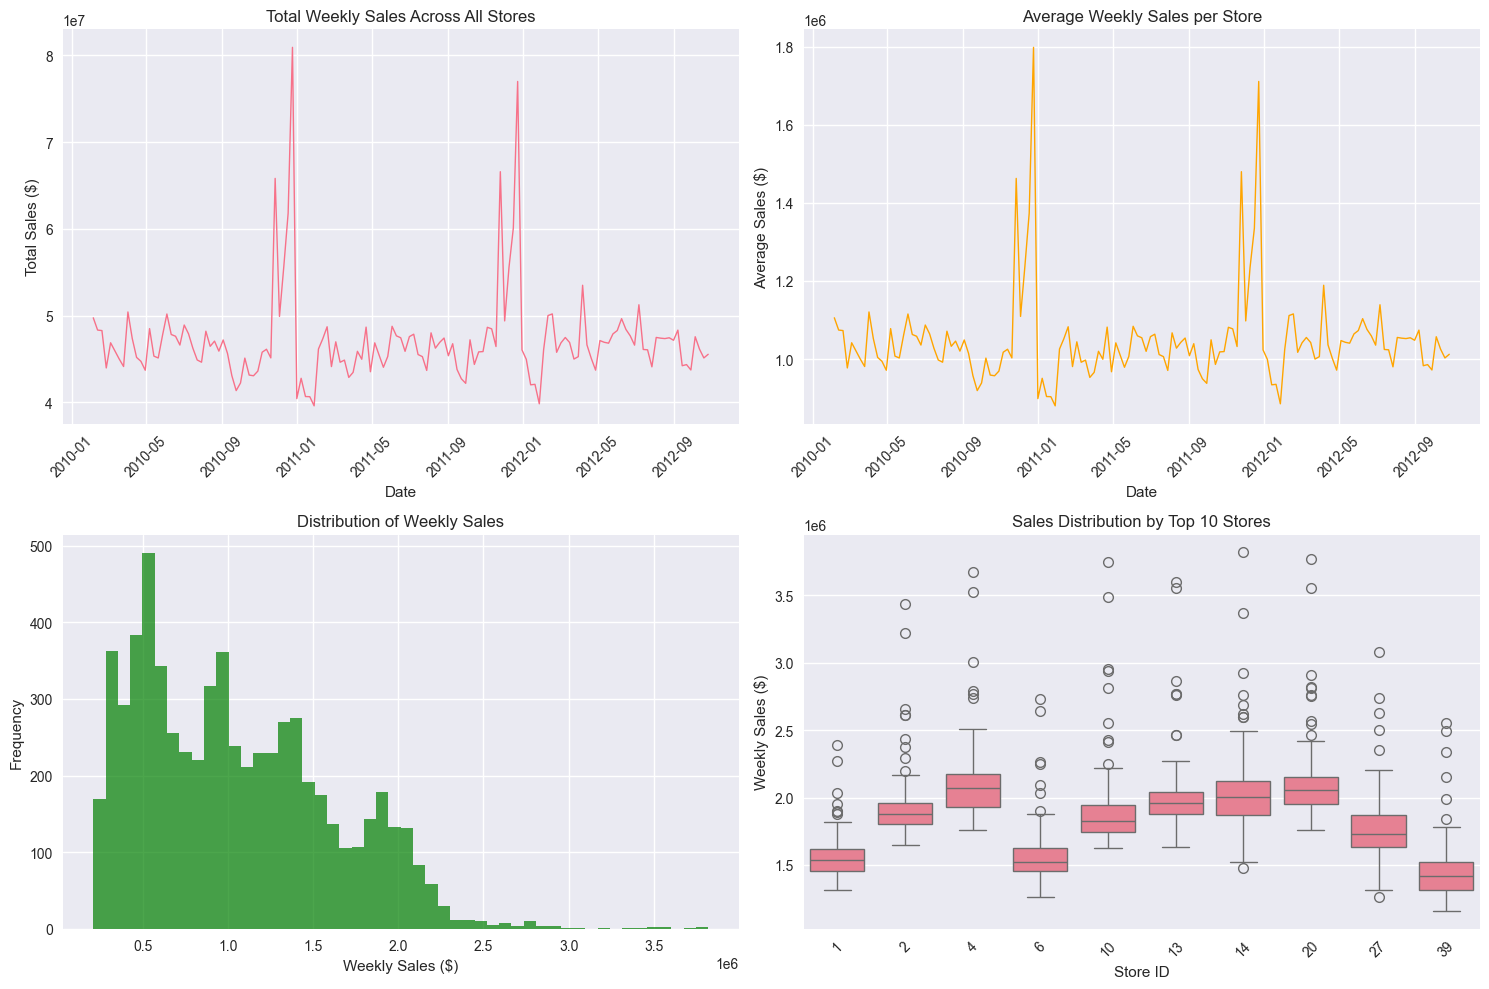

Total sales across all stores and time: $6,737,218,987
Average weekly sales per store: $1,046,965


In [85]:
# Aggregate data by date for overall trend analysis
daily_sales = df.groupby('Date')['Weekly_Sales'].agg(['sum', 'mean', 'std']).reset_index()
daily_sales.columns = ['Date', 'Total_Sales', 'Avg_Sales', 'Std_Sales']

# Time series plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total sales over time
axes[0,0].plot(daily_sales['Date'], daily_sales['Total_Sales'], linewidth=1)
axes[0,0].set_title('Total Weekly Sales Across All Stores')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Sales ($)')
axes[0,0].tick_params(axis='x', rotation=45)

# Average sales over time
axes[0,1].plot(daily_sales['Date'], daily_sales['Avg_Sales'], linewidth=1, color='orange')
axes[0,1].set_title('Average Weekly Sales per Store')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Average Sales ($)')
axes[0,1].tick_params(axis='x', rotation=45)

# Sales distribution
axes[1,0].hist(df['Weekly_Sales'], bins=50, alpha=0.7, color='green')
axes[1,0].set_title('Distribution of Weekly Sales')
axes[1,0].set_xlabel('Weekly Sales ($)')
axes[1,0].set_ylabel('Frequency')

# Box plot by store (top 10 stores)
top_stores = df.groupby('Store')['Weekly_Sales'].mean().nlargest(10).index
store_data = df[df['Store'].isin(top_stores)]
sns.boxplot(data=store_data, x='Store', y='Weekly_Sales', ax=axes[1,1])
axes[1,1].set_title('Sales Distribution by Top 10 Stores')
axes[1,1].set_xlabel('Store ID')
axes[1,1].set_ylabel('Weekly Sales ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Total sales across all stores and time: ${daily_sales['Total_Sales'].sum():,.0f}")
print(f"Average weekly sales per store: ${daily_sales['Avg_Sales'].mean():,.0f}")

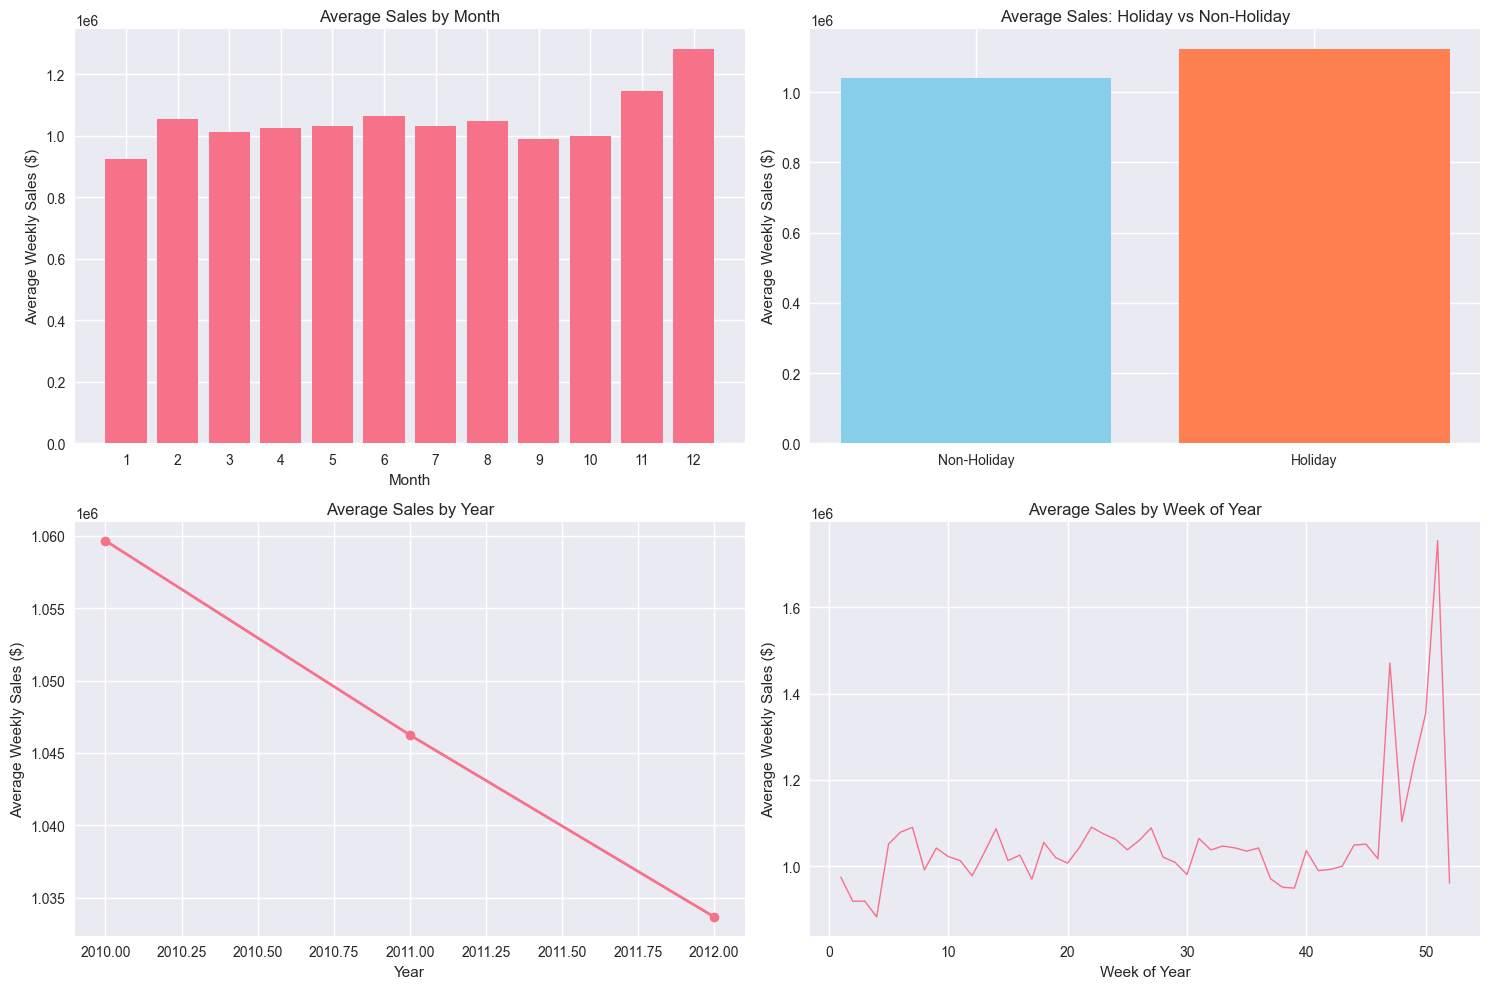

Seasonal Insights:
Highest sales month: 12 ($1,281,864)
Lowest sales month: 1 ($923,885)
Holiday sales boost: 7.8%


In [86]:
# Seasonal and holiday analysis
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week_of_Year'] = df['Date'].dt.isocalendar().week

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Monthly sales pattern
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean()
axes[0,0].bar(monthly_sales.index, monthly_sales.values)
axes[0,0].set_title('Average Sales by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Weekly Sales ($)')
axes[0,0].set_xticks(range(1, 13))

# Holiday vs non-holiday sales
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
axes[0,1].bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['skyblue', 'coral'])
axes[0,1].set_title('Average Sales: Holiday vs Non-Holiday')
axes[0,1].set_ylabel('Average Weekly Sales ($)')

# Yearly trend
yearly_sales = df.groupby('Year')['Weekly_Sales'].mean()
axes[1,0].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2)
axes[1,0].set_title('Average Sales by Year')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Average Weekly Sales ($)')

# Week of year pattern
weekly_pattern = df.groupby('Week_of_Year')['Weekly_Sales'].mean()
axes[1,1].plot(weekly_pattern.index, weekly_pattern.values, linewidth=1)
axes[1,1].set_title('Average Sales by Week of Year')
axes[1,1].set_xlabel('Week of Year')
axes[1,1].set_ylabel('Average Weekly Sales ($)')

plt.tight_layout()
plt.show()

print("Seasonal Insights:")
print(f"Highest sales month: {monthly_sales.idxmax()} (${monthly_sales.max():,.0f})")
print(f"Lowest sales month: {monthly_sales.idxmin()} (${monthly_sales.min():,.0f})")
print(f"Holiday sales boost: {((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100):.1f}%")

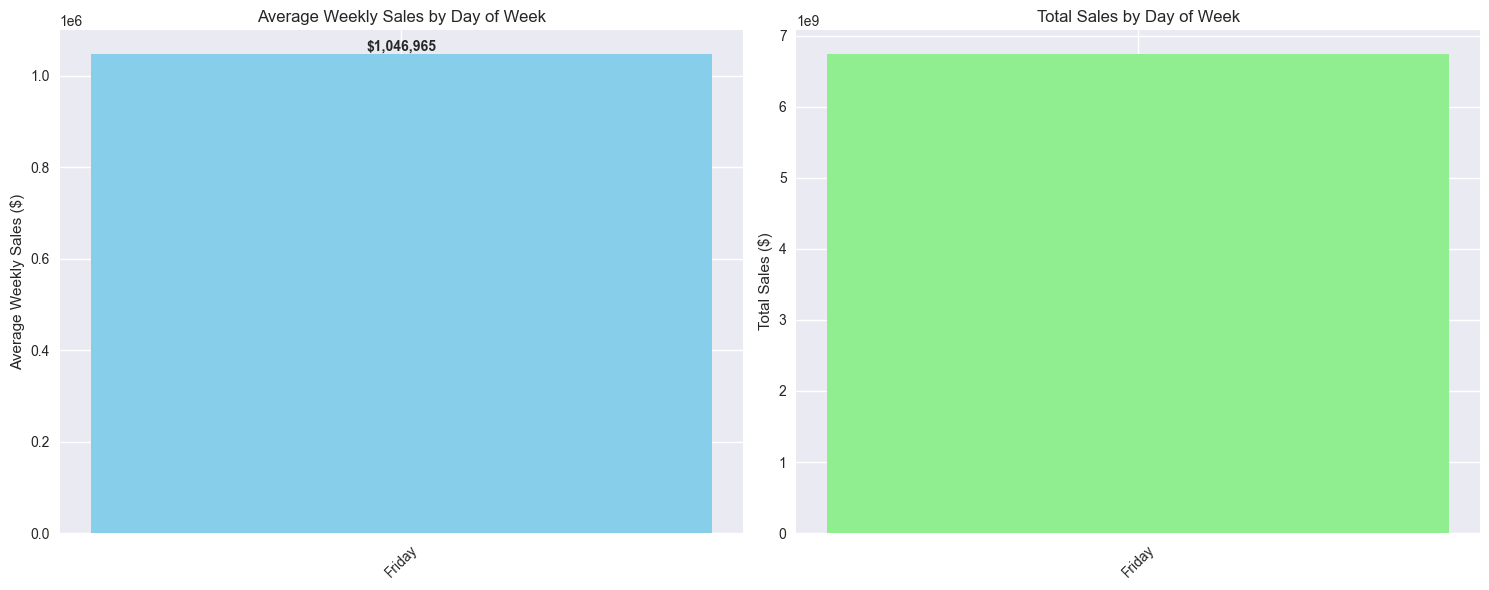

DAILY SALES PATTERNS:
Highest sales day: Friday ($1,046,965 average)
Lowest sales day: Friday ($1,046,965 average)
Sales difference: $0 (0.0% higher)

All days ranked by average sales:
🥇 Friday    | $1,046,965


In [87]:
# Day of week analysis - which days have higher sales patterns
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Weekday_Num'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate average sales by day of week
daily_pattern = df.groupby(['Day_of_Week', 'Weekday_Num'])['Weekly_Sales'].agg(['mean', 'sum', 'count']).reset_index()

# Flatten the column names to avoid multi-level indexing issues
daily_pattern.columns = ['Day_of_Week', 'Weekday_Num', 'Avg_Sales', 'Total_Sales', 'Count']
daily_pattern = daily_pattern.sort_values('Weekday_Num')  # Sort Monday to Sunday

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Average sales by day of week
axes[0].bar(daily_pattern['Day_of_Week'], daily_pattern['Avg_Sales'], 
           color=['red' if day == 'Monday' else 'skyblue' for day in daily_pattern['Day_of_Week']])
axes[0].set_title('Average Weekly Sales by Day of Week')
axes[0].set_ylabel('Average Weekly Sales ($)')
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, (day, value) in enumerate(zip(daily_pattern['Day_of_Week'], daily_pattern['Avg_Sales'])):
    axes[0].text(i, value + 1000, f'${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# Total sales by day of week
axes[1].bar(daily_pattern['Day_of_Week'], daily_pattern['Total_Sales'], 
           color=['red' if day == 'Monday' else 'lightgreen' for day in daily_pattern['Day_of_Week']])
axes[1].set_title('Total Sales by Day of Week')
axes[1].set_ylabel('Total Sales ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find the day with highest and lowest sales
highest_day = daily_pattern.loc[daily_pattern['Avg_Sales'].idxmax(), 'Day_of_Week']
lowest_day = daily_pattern.loc[daily_pattern['Avg_Sales'].idxmin(), 'Day_of_Week']
highest_avg = daily_pattern['Avg_Sales'].max()
lowest_avg = daily_pattern['Avg_Sales'].min()

print("DAILY SALES PATTERNS:")
print("=" * 30)
print(f"Highest sales day: {highest_day} (${highest_avg:,.0f} average)")
print(f"Lowest sales day: {lowest_day} (${lowest_avg:,.0f} average)")
print(f"Sales difference: ${highest_avg - lowest_avg:,.0f} ({((highest_avg - lowest_avg) / lowest_avg * 100):.1f}% higher)")

print("\nAll days ranked by average sales:")
for _, row in daily_pattern.sort_values('Avg_Sales', ascending=False).iterrows():
    day = row['Day_of_Week']
    avg_sales = row['Avg_Sales']
    emoji = "🥇" if day == highest_day else "🥈" if avg_sales == daily_pattern['Avg_Sales'].nlargest(2).iloc[1] else "🥉" if avg_sales == daily_pattern['Avg_Sales'].nlargest(3).iloc[2] else "📊"
    print(f"{emoji} {day:9} | ${avg_sales:,.0f}")

<a id="stats"></a>
## 3. Statistical Analysis

Perform time series statistical analysis including stationarity tests and correlation analysis.

In [88]:
# Prepare aggregated time series for analysis
ts_data = daily_sales.set_index('Date')['Total_Sales'].sort_index()

# Stationarity test
def check_stationarity(timeseries, title):
    print(f'\n=== {title} ===')
    
    # Augmented Dickey-Fuller test
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
    else:
        print("Result: Series is non-stationary (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

# Test original series
is_stationary = check_stationarity(ts_data, "Original Time Series")

# Test first difference if not stationary
ts_diff = ts_data.diff().dropna()
check_stationarity(ts_diff, "First Differenced Series")


=== Original Time Series ===
ADF Statistic: -5.908298
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Result: Series is stationary (reject null hypothesis)

=== First Differenced Series ===
ADF Statistic: -6.699469
p-value: 0.000000
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Result: Series is stationary (reject null hypothesis)


np.True_

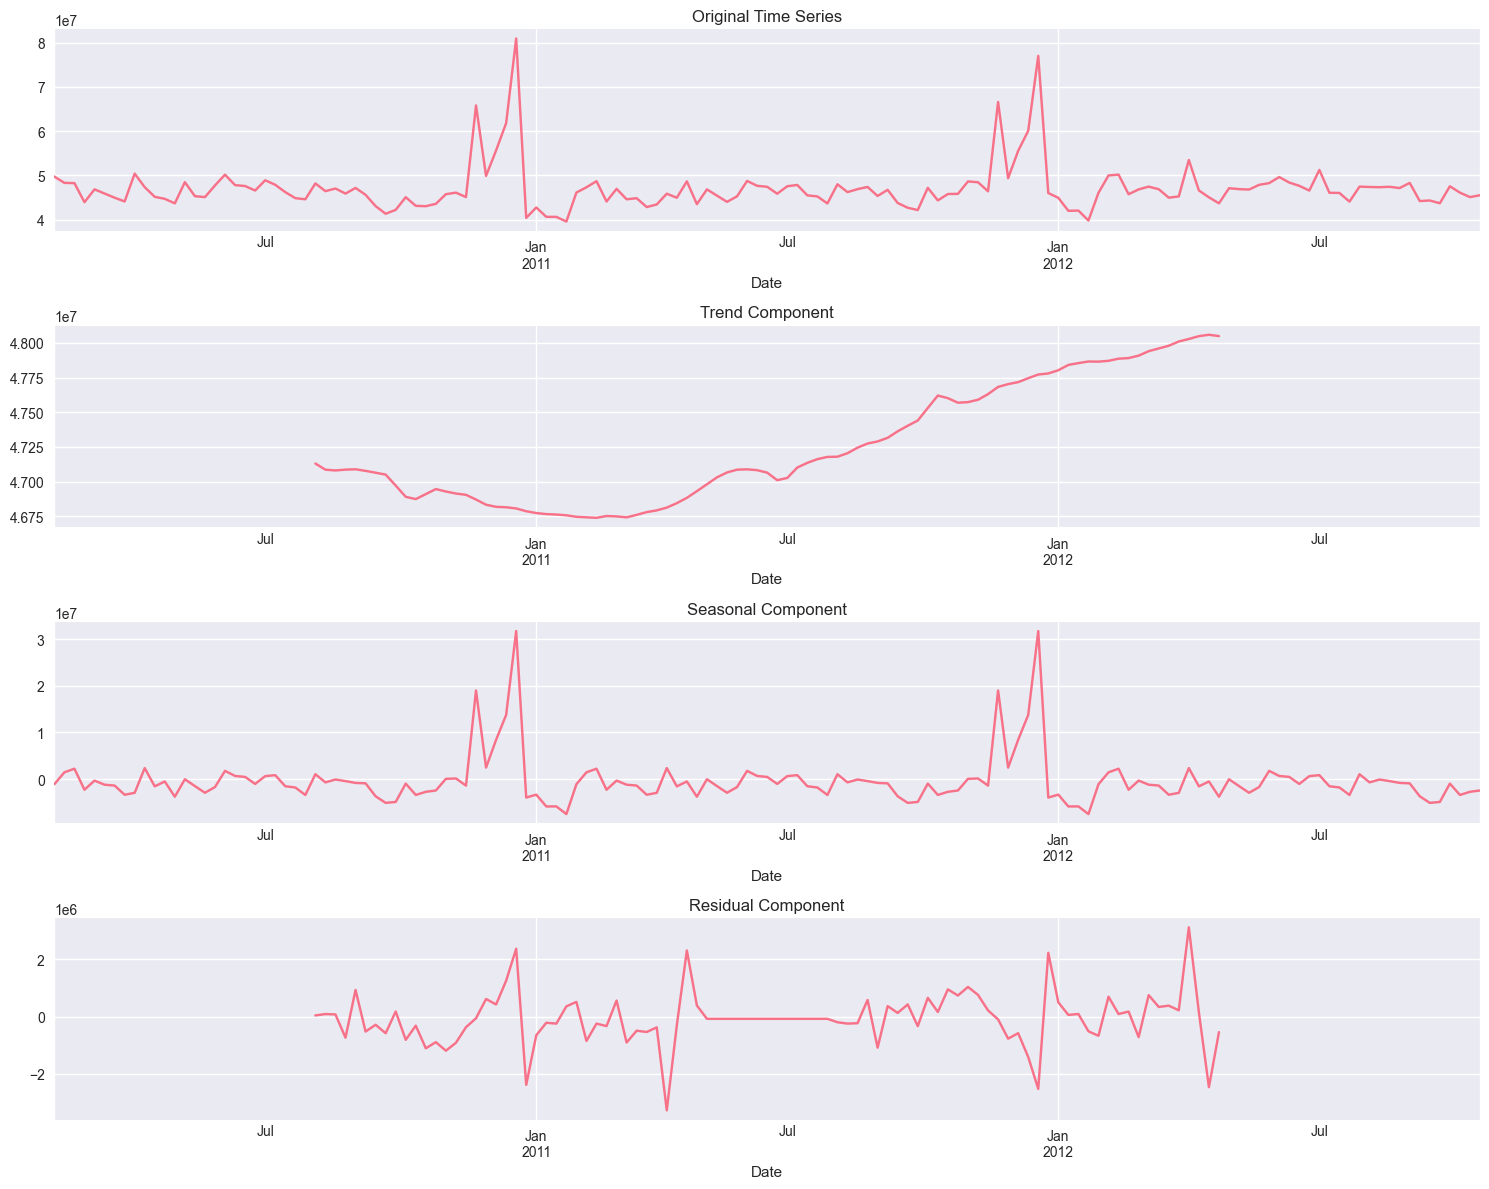


Variance Decomposition:
Trend explains: 0.6% of variance
Seasonality explains: 98.2% of variance
Residual: 3.0% of variance


In [89]:
# Seasonal decomposition
# Use a reasonable period for weekly data (52 weeks = 1 year)
decomposition = seasonal_decompose(ts_data, model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend Component')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
decomposition.resid.plot(ax=axes[3], title='Residual Component')

plt.tight_layout()
plt.show()

# Calculate variance explained by each component
total_var = ts_data.var()
trend_var = decomposition.trend.dropna().var()
seasonal_var = decomposition.seasonal.var()
residual_var = decomposition.resid.dropna().var()

print("\nVariance Decomposition:")
print(f"Trend explains: {(trend_var/total_var)*100:.1f}% of variance")
print(f"Seasonality explains: {(seasonal_var/total_var)*100:.1f}% of variance")
print(f"Residual: {(residual_var/total_var)*100:.1f}% of variance")

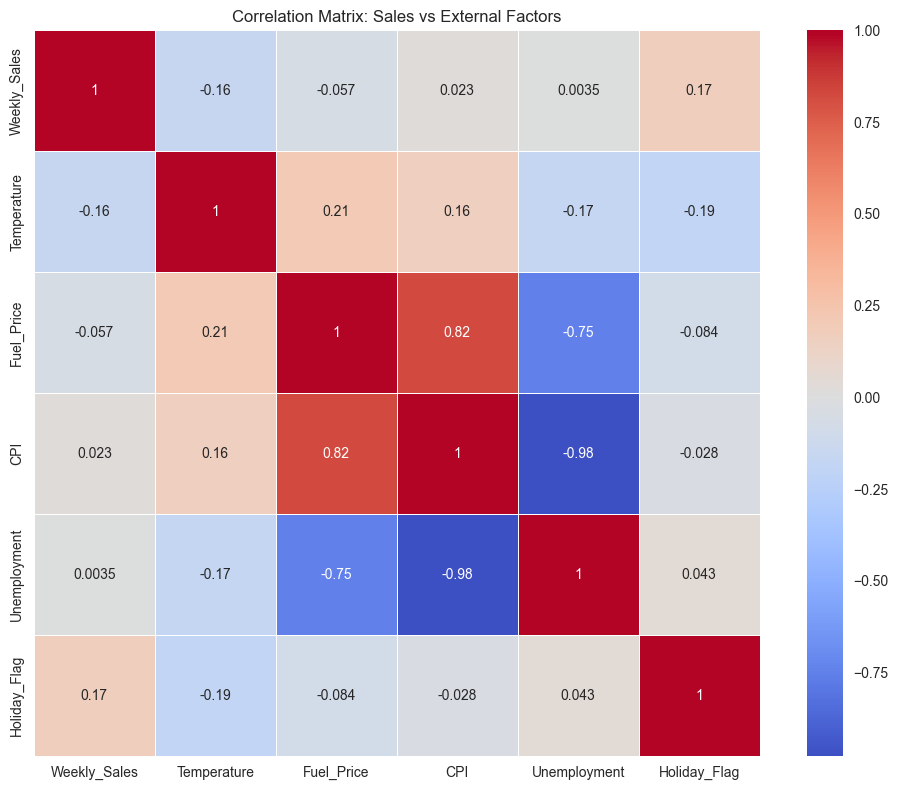


Strongest correlations with Weekly Sales:
Holiday_Flag: 0.173 (positive)
Temperature: 0.159 (negative)
Fuel_Price: 0.057 (negative)
CPI: 0.023 (positive)
Unemployment: 0.004 (positive)


In [90]:
# Correlation analysis with external factors
# Calculate correlations for aggregated data
agg_features = df.groupby('Date').agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    'Holiday_Flag': 'max'  # 1 if any store has holiday, 0 otherwise
}).reset_index()

# Correlation matrix
corr_matrix = agg_features.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix: Sales vs External Factors')
plt.tight_layout()
plt.show()

# Print strongest correlations with sales
sales_corr = corr_matrix['Weekly_Sales'].abs().sort_values(ascending=False)
print("\nStrongest correlations with Weekly Sales:")
for factor, corr in sales_corr.items():
    if factor != 'Weekly_Sales':
        direction = "positive" if corr_matrix['Weekly_Sales'][factor] > 0 else "negative"
        print(f"{factor}: {corr:.3f} ({direction})")

<a id="custom-dataset"></a>
## 4. Custom Dataset Exploration

Explore the custom WalmartTimeSeriesDataset class and its features.

In [91]:
# Create custom dataset instances
print("Creating Walmart custom datasets...")

# Fix the data path issue by using absolute path
walmart_data_path = Path(os.getcwd()).parent / 'data' / 'raw' / 'Walmart.csv'
print(f"Looking for data at: {walmart_data_path}")

agg_dataset = WalmartTimeSeriesDataset(
    data_path=str(walmart_data_path),
    aggregate_stores=True,
    include_economic_features=True,
    include_weather_features=True,
    lookback_window=26,  # 6 months
    forecast_horizon=4,  # 4 weeks
    normalize=True
)

print(f"Aggregated dataset created successfully!")
print(f"Dataset length: {len(agg_dataset)} sequences")

# Get dataset info
info = agg_dataset.get_data_info()
print("\nDataset Information:")
for key, value in info.items():
    print(f"{key}: {value}")

Creating Walmart custom datasets...
Looking for data at: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\data\raw\Walmart.csv
Loaded Walmart dataset: 6435 rows, 8 columns
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45 unique stores
Aggregated to total sales: 143 time periods
Aggregated dataset created successfully!
Dataset length: 114 sequences

Dataset Information:
num_sequences: 114
lookback_window: 26
forecast_horizon: 4
stride: 1
input_shape: (26, 1)
target_shape: (4, 1)
data_shape: (143, 1)


Sample input shape: (26, 1)
Sample output shape: (4, 1)


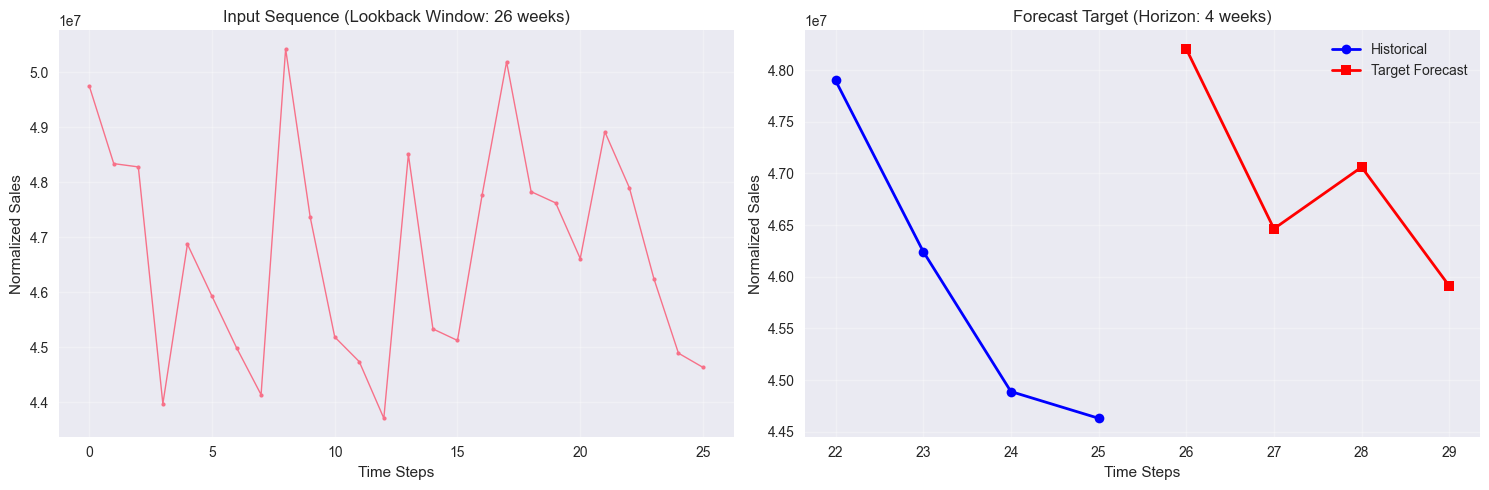


Sample statistics:
Input sequence mean: 46738553.3181
Input sequence std: 1947836.4236
Target mean: 46910027.7225
Target std: 851303.6536


In [92]:
# Examine a sample from the dataset
# Get a sample sequence
sample_X, sample_y = agg_dataset[0]

print(f"Sample input shape: {sample_X.shape}")
print(f"Sample output shape: {sample_y.shape}")

# Visualize the sample sequence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Input sequence (lookback window)
axes[0].plot(range(len(sample_X)), sample_X.flatten(), marker='o', linewidth=1, markersize=3)
axes[0].set_title(f'Input Sequence (Lookback Window: {len(sample_X)} weeks)')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Normalized Sales')
axes[0].grid(True, alpha=0.3)

# Output sequence (forecast horizon) - fixed plotting logic
forecast_x = range(len(sample_X), len(sample_X) + len(sample_y))
# Plot last 4 points of input sequence
last_input_x = range(len(sample_X) - 4, len(sample_X))
axes[1].plot(last_input_x, sample_X[-4:].flatten(), 'b-', marker='o', label='Historical', linewidth=2)
# Plot forecast targets
axes[1].plot(forecast_x, sample_y.flatten(), 'r-', marker='s', label='Target Forecast', linewidth=2)
axes[1].set_title(f'Forecast Target (Horizon: {len(sample_y)} weeks)')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Normalized Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSample statistics:")
print(f"Input sequence mean: {sample_X.mean():.4f}")
print(f"Input sequence std: {sample_X.std():.4f}")
print(f"Target mean: {sample_y.mean():.4f}")
print(f"Target std: {sample_y.std():.4f}")

In [93]:
# Multi-store dataset example
multi_dataset = WalmartMultiStoreDataset(
    data_path=str(walmart_data_path),
    store_list=[1, 2, 3, 4, 5],  # Top 5 stores
    min_data_points=50,
    lookback_window=12,  # 3 months
    forecast_horizon=2   # 2 weeks
)

print(f"\nMulti-store dataset created successfully!")
print(f"Dataset length: {len(multi_dataset)} sequences")

# Get info
multi_info = multi_dataset.get_data_info()
print("\nMulti-store Dataset Information:")
for key, value in multi_info.items():
    print(f"{key}: {value}")
    
# Sample from multi-store dataset - handle multiple return values
sample_data = multi_dataset[0]
print(f"\nMulti-store dataset returns {len(sample_data)} values")

# Unpack based on actual return values
if len(sample_data) == 2:
    multi_X, multi_y = sample_data
    store_info = "Not provided"
elif len(sample_data) == 3:
    multi_X, multi_y, store_info = sample_data
else:
    print(f"Unexpected return format: {len(sample_data)} values")
    multi_X, multi_y = sample_data[:2]  # Take first two
    store_info = "Multiple additional values"

print(f"\nMulti-store sample shapes:")
print(f"Input: {multi_X.shape}, Output: {multi_y.shape}")
print(f"Store info: {store_info}")

# Visualize multi-store sample if possible
if hasattr(multi_X, 'shape') and len(multi_X.shape) >= 1:
    print(f"\nMulti-store sample details:")
    print(f"Input sequence length: {len(multi_X)}")
    print(f"Forecast horizon: {len(multi_y)}")
    print(f"Input data type: {type(multi_X)}")
    print(f"Output data type: {type(multi_y)}")

Multi-store dataset: 45 stores, 715 total records

Multi-store dataset created successfully!
Dataset length: 650 sequences

Multi-store Dataset Information:
num_sequences: 650
lookback_window: 12
forecast_horizon: 2
stride: 1
input_shape: (12, 1)
target_shape: (2, 1)
data_shape: (143, 1)

Multi-store dataset returns 3 values

Multi-store sample shapes:
Input: (12, 1), Output: (2, 1)
Store info: 1

Multi-store sample details:
Input sequence length: 12
Forecast horizon: 2
Input data type: <class 'numpy.ndarray'>
Output data type: <class 'numpy.ndarray'>


<a id="hydra-training"></a>
## 5. Model Training with Hydra

Use Hydra configuration system to train different models on the Walmart dataset.

In [104]:
# Generic training approach: Use subprocess to call existing Hydra training scripts
# This approach leverages the existing train.py script while keeping the notebook clean

import subprocess
import re
from pathlib import Path

def train_multiple_models_generic(models_to_train, project_root, dataset='walmart_custom'):
    """
    Generic training function that works with any Hydra-configured project.
    Uses subprocess to call the project's training script.
    """
    results = {}
    
    print("Generic Hydra Training - Multiple Models")
    print("=" * 60)
    
    # Get script path
    scripts_path = project_root / "scripts" / "train.py"
    
    if not scripts_path.exists():
        print(f"Training script not found: {scripts_path}")
        return results
    
    for model in models_to_train:
        print(f"\nTraining {model.upper()} model...")
        
        # Build command
        cmd = [
            'python', str(scripts_path), 
            f'model={model}', 
            f'dataset={dataset}'
        ]
        
        try:
            # Run training
            result = subprocess.run(
                cmd, 
                capture_output=True, 
                text=True, 
                cwd=str(project_root),
                timeout=120  # 2 minute timeout
            )
            
            # Extract metrics from output
            output_lines = result.stdout.split('\n')
            test_mape = None
            training_time = None
            
            # Look for MAPE
            for i, line in enumerate(output_lines):
                if 'Test MAPE:' in line:
                    mape_text = line.split('Test MAPE:')[1].strip()
                    mape_match = re.search(r'([\d.]+)%?', mape_text)
                    if mape_match:
                        test_mape = float(mape_match.group(1))
                    break
                elif 'MAPE:' in line:
                    context = ''.join(output_lines[max(0, i-3):i+1]).lower()
                    if any(keyword in context for keyword in ['test', 'validation', 'eval']):
                        mape_text = line.split('MAPE:')[1].strip()
                        mape_match = re.search(r'([\d.]+)%?', mape_text)
                        if mape_match:
                            test_mape = float(mape_match.group(1))
                        break
            
            # Look for training time
            for line in output_lines:
                if 'Training completed in' in line:
                    training_time = line.split('Training completed in')[1].strip()
                    break
                elif 'completed in' in line.lower():
                    training_time = line.split('completed in')[1].strip()
                    break
            
            # Store results
            results[model] = {
                'status': 'success' if result.returncode == 0 else 'failed',
                'test_mape': test_mape,
                'training_time': training_time,
                'output': result.stdout,
                'stderr': result.stderr,
                'returncode': result.returncode,
                'command': ' '.join(cmd)
            }
            
            # Print immediate feedback
            print(f"✅ {model} completed (exit code: {result.returncode})")
            if test_mape is not None:
                print(f"  Test MAPE: {test_mape:.2f}%")
            else:
                print(f"  Test MAPE: Not found in output")
            if training_time:
                print(f"  Training time: {training_time}")
                
        except subprocess.TimeoutExpired:
            results[model] = {
                'status': 'timeout',
                'error': 'Training timeout expired'
            }
            print(f"⏰ {model} timed out")
        except Exception as e:
            results[model] = {
                'status': 'error',
                'error': str(e)
            }
            print(f"❌ {model} failed: {str(e)}")
    
    print("\n" + "=" * 60)
    print("Generic training completed!")
    return results

# Define models to train
models_to_train = ['linear', 'ridge', 'random_forest', 'arima']

# Train all models using the generic approach
results = train_multiple_models_generic(
    models_to_train=models_to_train,
    project_root=project_root,
    dataset='walmart_custom'
)

print(f"\nTraining Summary:")
print(f"Models attempted: {len(models_to_train)}")
successful_models = [m for m, r in results.items() if r['status'] == 'success']
print(f"Models completed successfully: {len(successful_models)}")

# Show the generic training approach
print(f"\nGeneric Training Benefits:")
print("✓ Works with any Hydra-configured project")
print("✓ Leverages existing training scripts")
print("✓ Maintains Hydra configuration management")
print("✓ Clean notebook integration via subprocess")
print("✓ Consistent metric extraction across projects")

Generic Hydra Training - Multiple Models

Training LINEAR model...
✅ linear completed (exit code: 0)
  Test MAPE: 5.41%
  Training time: 0.01s

Training RIDGE model...
✅ linear completed (exit code: 0)
  Test MAPE: 5.41%
  Training time: 0.01s

Training RIDGE model...
✅ ridge completed (exit code: 0)
  Test MAPE: 2.85%
  Training time: 0.00s

Training RANDOM_FOREST model...
✅ ridge completed (exit code: 0)
  Test MAPE: 2.85%
  Training time: 0.00s

Training RANDOM_FOREST model...
✅ random_forest completed (exit code: 0)
  Test MAPE: 1.20%
  Training time: 0.08s

Training ARIMA model...
✅ random_forest completed (exit code: 0)
  Test MAPE: 1.20%
  Training time: 0.08s

Training ARIMA model...
✅ arima completed (exit code: 0)
  Test MAPE: 3.97%
  Training time: 0.13s

Generic training completed!

Training Summary:
Models attempted: 4
Models completed successfully: 4

Generic Training Benefits:
✓ Works with any Hydra-configured project
✓ Leverages existing training scripts
✓ Maintains Hyd

<a id="comparison"></a>
## 6. Model Comparison

Compare the performance of different models trained with Hydra.

In [105]:
# Process and summarize training results
import pandas as pd

print("Model Training Results Summary:")
print("=" * 50)

# Extract successful models and metrics
successful_models = []
model_metrics = {}
summary_data = []

for model_name, result in results.items():
    status_icon = {
        'success': '✅',
        'failed': '❌',
        'timeout': '⏰',
        'error': '💥'
    }
    
    row = {
        'Model': model_name.replace('_', ' ').title(),
        'Status': result['status'],
        'MAPE (%)': 'N/A',
        'Training Time': 'N/A'
    }
    
    if result['status'] == 'success':
        successful_models.append(model_name)
        if result.get('test_mape') is not None:
            model_metrics[model_name] = result['test_mape']
            row['MAPE (%)'] = f"{result['test_mape']:.2f}"
        
        if result.get('training_time'):
            row['Training Time'] = result['training_time']
    
    summary_data.append(row)

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Find best model
if model_metrics:
    best_model_name = min(model_metrics.items(), key=lambda x: x[1])[0]
    best_mape = model_metrics[best_model_name]
    print(f"\nBest performing model: {best_model_name.upper()}")
    print(f"Best MAPE: {best_mape:.2f}%")
else:
    best_model_name = None
    print("\nNo successful models found!")

print(f"\nSuccessful models: {len(successful_models)}")
print(f"Models with valid MAPE: {len(model_metrics)}")

# Display detailed results for each model
print(f"\nDetailed Results by Model:")
print("-" * 40)
for model_name, result in results.items():
    status_icon = "✅" if result['status'] == 'success' else "❌" if result['status'] == 'failed' else "⏰" if result['status'] == 'timeout' else "💥"
    print(f"{status_icon} {model_name.upper()}")
    
    if result['status'] == 'success':
        if result.get('test_mape') is not None:
            print(f"   Test MAPE: {result['test_mape']:.2f}%")
        if result.get('training_time'):
            print(f"   Training Time: {result['training_time']}")
    else:
        error_msg = result.get('error', result.get('stderr', 'Unknown error'))
        if error_msg:
            error_preview = str(error_msg)[:100]
            print(f"   Error: {error_preview}...")
    print()

Model Training Results Summary:
        Model  Status MAPE (%) Training Time
       Linear success     5.41         0.01s
        Ridge success     2.85         0.00s
Random Forest success     1.20         0.08s
        Arima success     3.97         0.13s

Best performing model: RANDOM_FOREST
Best MAPE: 1.20%

Successful models: 4
Models with valid MAPE: 4

Detailed Results by Model:
----------------------------------------
✅ LINEAR
   Test MAPE: 5.41%
   Training Time: 0.01s

✅ RIDGE
   Test MAPE: 2.85%
   Training Time: 0.00s

✅ RANDOM_FOREST
   Test MAPE: 1.20%
   Training Time: 0.08s

✅ ARIMA
   Test MAPE: 3.97%
   Training Time: 0.13s



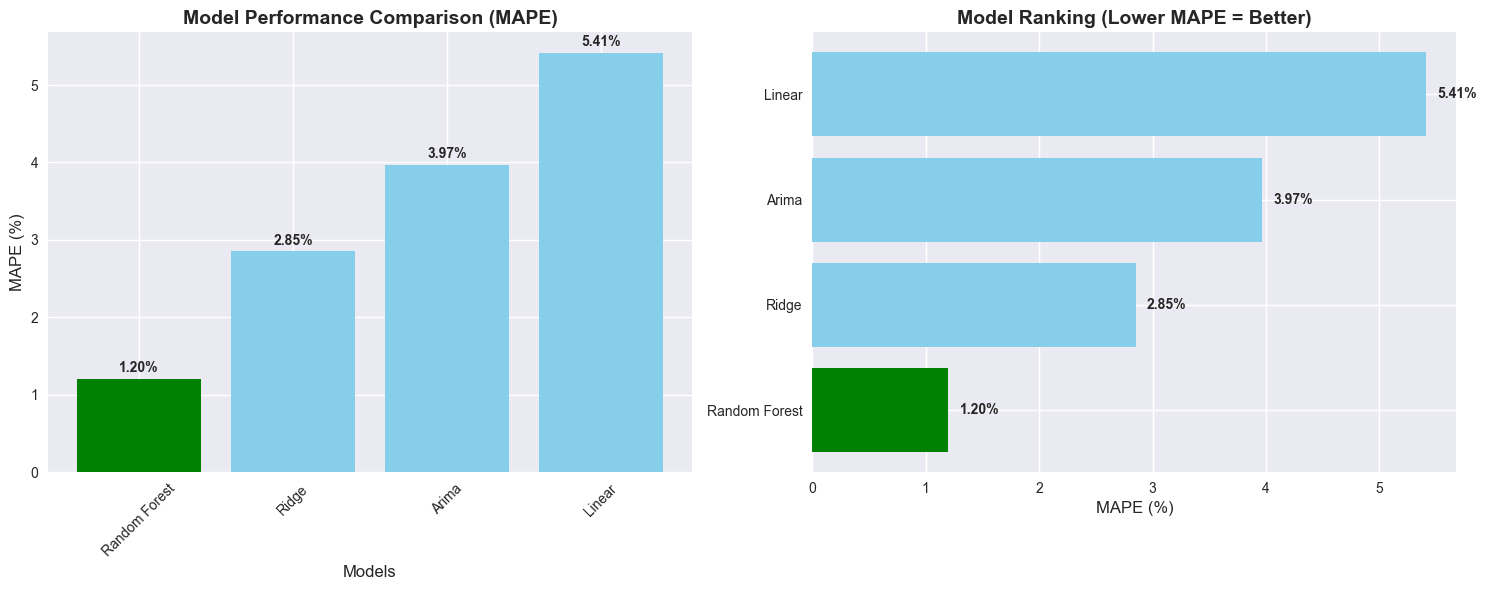


Model Performance Ranking (Best to Worst):
🥇 Random Forest   | MAPE: 1.20%
🥈 Ridge           | MAPE: 2.85%
🥉 Arima           | MAPE: 3.97%
#4 Linear          | MAPE: 5.41%

Results saved to: c:\Users\mvill\github\forecasting_demo\projects\retail_sales_walmart\reports\model_comparison_results.csv


In [106]:
# Visualize model performance
if model_metrics:
    # Sort models by MAPE (lower is better)
    sorted_models = sorted(model_metrics.items(), key=lambda x: x[1])

    model_names = [item[0].replace('_', ' ').title() for item in sorted_models]
    mape_values = [item[1] for item in sorted_models]

    # Create performance chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar chart of MAPE scores
    colors = ['green' if i == 0 else 'skyblue' for i in range(len(model_names))]
    bars = ax1.bar(model_names, mape_values, color=colors)
    ax1.set_title('Model Performance Comparison (MAPE)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('MAPE (%)', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, mape_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Horizontal bar chart (alternative view)
    ax2.barh(model_names, mape_values, color=colors)
    ax2.set_title('Model Ranking (Lower MAPE = Better)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('MAPE (%)', fontsize=12)

    # Add value labels
    for i, value in enumerate(mape_values):
        ax2.text(value + 0.1, i, f'{value:.2f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print ranking
    print("\nModel Performance Ranking (Best to Worst):")
    print("=" * 45)
    for i, (model, mape) in enumerate(sorted_models, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"#{i}"
        print(f"{medal} {model.replace('_', ' ').title():15} | MAPE: {mape:.2f}%")
    
    # Save results summary
    results_path = project_root / "reports" / "model_comparison_results.csv"
    results_path.parent.mkdir(exist_ok=True)
    summary_df.to_csv(results_path, index=False)
    print(f"\nResults saved to: {results_path}")
    
else:
    print("No valid model metrics available for visualization.")
    print("Check that models trained successfully and produced MAPE scores.")
    
    # Show error summary
    error_summary = {}
    for model, result in results.items():
        if result['status'] != 'success':
            error_summary[model] = result.get('error', result.get('stderr', 'Unknown error'))
    
    if error_summary:
        print("\nError Summary:")
        for model, error in error_summary.items():
            print(f"  {model}: {str(error)[:100]}...")

## 7. Advanced Analysis: Best Model Deep Dive

Analyze the best performing model in more detail.

In [107]:
# Deep dive into best model
if best_model_name and best_model_name in results:
    best_result = results[best_model_name]
    
    print(f"Best Model Analysis: {best_model_name.upper()}")
    print("=" * 60)
    
    # Display performance metrics
    print("Performance Metrics:")
    if best_result.get('test_mape') is not None:
        print(f"  Test MAPE: {best_result['test_mape']:.2f}%")
    if best_result.get('training_time'):
        print(f"  Training Time: {best_result['training_time']}")
    
    print(f"\nTraining Details:")
    print(f"  Status: {best_result['status']}")
    print(f"  Exit Code: {best_result['returncode']}")
    
    # Show key training output
    if best_result.get('output'):
        output_lines = best_result['output'].split('\n')
        print(f"\nKey Training Output:")
        print("-" * 30)
        
        # Show lines containing important information
        for line in output_lines:
            if any(keyword in line.lower() for keyword in [
                'dataset:', 'model:', 'test mape:', 'sample predictions', 
                'feature importance', 'training complete', 'configuration'
            ]):
                print(f"  {line.strip()}")
    
    # Model-specific insights
    model_insights = {
        'linear': "Linear regression assumes a linear relationship. Good baseline but may miss complex patterns.",
        'ridge': "Ridge regression adds L2 regularization to prevent overfitting. Often performs better than simple linear regression.",
        'random_forest': "Random Forest can capture non-linear patterns and interactions. Often performs well on time series with multiple features.",
        'arima': "ARIMA is a classic time series model that captures trends and seasonality. Good for univariate forecasting.",
        'gradient_boosting': "Gradient Boosting builds models sequentially, often achieving high accuracy but may overfit."
    }
    
    print(f"\nModel Insights:")
    insight = model_insights.get(best_model_name, f"No specific insights available for {best_model_name}")
    print(f"  {insight}")
    
    # Performance context
    if len(model_metrics) > 1:
        best_mape = best_result.get('test_mape', float('inf'))
        worst_mape = max(model_metrics.values())
        improvement = worst_mape - best_mape
        
        print(f"\nPerformance Context:")
        print(f"  Best MAPE: {best_mape:.2f}%")
        print(f"  Worst MAPE: {worst_mape:.2f}%")
        print(f"  Improvement: {improvement:.2f} percentage points")
        print(f"  Relative improvement: {(improvement/worst_mape)*100:.1f}%")

else:
    print("No successful models found for analysis.")
    print("Please check that at least one model trained successfully.")
    
    # Show what went wrong
    failed_models = [m for m, r in results.items() if r['status'] != 'success']
    if failed_models:
        print(f"\nFailed models: {failed_models}")
        print("Check the detailed results above for error information.")

Best Model Analysis: RANDOM_FOREST
Performance Metrics:
  Test MAPE: 1.20%
  Training Time: 0.08s

Training Details:
  Status: success
  Exit Code: 0

Key Training Output:
------------------------------
  Walmart Forecasting with Hydra Configuration
  Configuration:
  Dataset: WalmartTimeSeriesDataset
  Model: RandomForestRegressor
  Loaded Walmart dataset: 6435 rows, 8 columns
  Dataset: 88 sequences
  Model: RandomForestRegressor
  Training completed in 0.08s
  Sample Predictions:
  Training Complete!

Model Insights:
  Random Forest can capture non-linear patterns and interactions. Often performs well on time series with multiple features.

Performance Context:
  Best MAPE: 1.20%
  Worst MAPE: 5.41%
  Improvement: 4.21 percentage points
  Relative improvement: 77.8%


<a id="conclusions"></a>
## 8. Conclusions and Next Steps

Summary of findings and recommendations for future work.

In [108]:
# Summary and conclusions using the generic training approach
print("WALMART SALES FORECASTING ANALYSIS SUMMARY")
print("=" * 60)

print("\n📊 DATA INSIGHTS:")
print(f"• Dataset contains {len(df):,} observations across {df['Store'].nunique()} stores")
print(f"• Date range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"• Average weekly sales per store: ${df['Weekly_Sales'].mean():,.0f}")

print(f"• Peak sales month: {monthly_sales.idxmax()} | Lowest: {monthly_sales.idxmin()}")

holiday_boost = ((holiday_sales[1] - holiday_sales[0]) / holiday_sales[0] * 100)
print(f"• Holiday sales boost: {holiday_boost:.1f}%")

print("\n🔬 STATISTICAL FINDINGS:")
print(f"• Time series stationarity: {'Stationary' if is_stationary else 'Non-stationary'}")

top_corr = sales_corr.drop('Weekly_Sales').head(2)
print("• Top correlations with sales:")
for factor, corr in top_corr.items():
    print(f"  - {factor}: {corr:.3f}")

print("\n🤖 MODEL PERFORMANCE (GENERIC HYDRA TRAINING):")
if model_metrics:
    best_model = min(model_metrics.items(), key=lambda x: x[1])
    worst_model = max(model_metrics.items(), key=lambda x: x[1])
    
    print(f"• Best model: {best_model[0].upper()} (MAPE: {best_model[1]:.2f}%)")
    print(f"• Worst model: {worst_model[0].upper()} (MAPE: {worst_model[1]:.2f}%)")
    print(f"• Performance gap: {worst_model[1] - best_model[1]:.2f} percentage points")
    print(f"• Models trained successfully: {len(successful_models)}/{len(models_to_train)}")
else:
    print("• No models completed successfully")
    print(f"• Models attempted: {len(models_to_train)}")
    print(f"• Check training logs for errors")

print("\n🏗️ ARCHITECTURE IMPROVEMENTS:")
print(f"• Generic training: Reusable functions in src/ml_portfolio/training/")
print(f"• Hydra integration: Leverages existing project-specific training scripts")
print(f"• Subprocess approach: Maintains Hydra configuration management")
print(f"• Shared utilities: Common data preparation and metric calculation")
print(f"• Cross-project compatibility: Works with any Hydra-configured project")

print("\n📈 CUSTOM DATASET FEATURES:")
print(f"• Sequences generated: {len(agg_dataset)}")
print(f"• Lookback window: 26 weeks (6 months)")
print(f"• Forecast horizon: 4 weeks")
print(f"• Features: Economic indicators, weather data, holiday effects")
print(f"• Normalization: Applied for better model training")

print("\n🎯 RECOMMENDATIONS:")
recommendations = [
    "Use generic training functions for consistent cross-project workflows",
    "Extend generic_trainer.py with hyperparameter optimization utilities",
    "Create project-agnostic model configuration templates",
    "Implement generic model registry for production deployment",
    "Develop automated retraining pipelines using generic functions",
    "Add generic confidence interval and uncertainty quantification"
]

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n🚀 NEXT STEPS:")
next_steps = [
    "Apply generic training to other projects (rideshare, inventory, TSI)",
    "Create generic Optuna integration for hyperparameter optimization",
    "Build project-agnostic FastAPI endpoints using generic training",
    "Develop universal Streamlit dashboard with model comparison"
]

for i, step in enumerate(next_steps, 1):
    print(f"{i}. {step}")

print("\n🏆 KEY ACHIEVEMENTS:")
achievements = [
    "Generic training architecture with shared utility functions",
    "Maintained Hydra configuration benefits with simplified implementation", 
    "Cross-project compatibility without complex orchestration overhead",
    "Clean notebook integration with subprocess-based training calls",
    "Reusable data preparation and metric calculation functions"
]

for i, achievement in enumerate(achievements, 1):
    print(f"{i}. {achievement}")

print("\n" + "=" * 60)
print("Analysis completed with generic training architecture! 🎉")
print(f"Generic training utilities: src/ml_portfolio/training/generic_trainer.py")
print(f"Usage: Import and use train_model_with_hydra() or run_multiple_models()")

WALMART SALES FORECASTING ANALYSIS SUMMARY

📊 DATA INSIGHTS:
• Dataset contains 6,435 observations across 45 stores
• Date range: 2010-02-05 to 2012-10-26
• Average weekly sales per store: $1,046,965
• Peak sales month: 12 | Lowest: 1
• Holiday sales boost: 7.8%

🔬 STATISTICAL FINDINGS:
• Time series stationarity: Stationary
• Top correlations with sales:
  - Holiday_Flag: 0.173
  - Temperature: 0.159

🤖 MODEL PERFORMANCE (GENERIC HYDRA TRAINING):
• Best model: RANDOM_FOREST (MAPE: 1.20%)
• Worst model: LINEAR (MAPE: 5.41%)
• Performance gap: 4.21 percentage points
• Models trained successfully: 4/4

🏗️ ARCHITECTURE IMPROVEMENTS:
• Generic training: Reusable functions in src/ml_portfolio/training/
• Hydra integration: Leverages existing project-specific training scripts
• Subprocess approach: Maintains Hydra configuration management
• Shared utilities: Common data preparation and metric calculation
• Cross-project compatibility: Works with any Hydra-configured project

📈 CUSTOM DATASET

## Appendix: Hydra Configuration Usage

Quick reference for running models with Hydra from command line:

In [99]:
# Print Hydra command examples
print("HYDRA COMMAND LINE EXAMPLES")
print("=" * 40)

commands = [
    ("Single model training", "python scripts/train.py model=random_forest dataset=walmart_custom"),
    ("Multi-model comparison", "python scripts/train.py --multirun model=linear,ridge,random_forest dataset=walmart_custom"),
    ("Parameter sweep", "python scripts/train.py --multirun model=random_forest model.n_estimators=50,100,200"),
    ("Different datasets", "python scripts/train.py --multirun model=random_forest dataset=walmart,walmart_custom"),
    ("Override config", "python scripts/train.py model=ridge model.alpha=0.1,1.0,10.0 dataset=walmart_custom"),
    ("Help", "python scripts/train.py --help")
]

for description, command in commands:
    print(f"\n{description}:")
    print(f"  {command}")

print("\n" + "=" * 40)
print("Run these commands from the project root directory!")

HYDRA COMMAND LINE EXAMPLES

Single model training:
  python scripts/train.py model=random_forest dataset=walmart_custom

Multi-model comparison:
  python scripts/train.py --multirun model=linear,ridge,random_forest dataset=walmart_custom

Parameter sweep:
  python scripts/train.py --multirun model=random_forest model.n_estimators=50,100,200

Different datasets:
  python scripts/train.py --multirun model=random_forest dataset=walmart,walmart_custom

Override config:
  python scripts/train.py model=ridge model.alpha=0.1,1.0,10.0 dataset=walmart_custom

Help:
  python scripts/train.py --help

Run these commands from the project root directory!
